This is modified notebook, refactored and optimized for serial use. <br>Last use is on the rerun finetuning.

In [1]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report

In [38]:
import os
from math import pi

In [11]:
label_to_numerical_multi = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}


numerical_to_label_multi = {v: f"{k}" for k, v in label_to_numerical_multi.items()}
numerical_to_label_multi

{0: 'Remaining',
 1: 'Non-systematic-review',
 2: 'Human-non-RCT-non-drug-intervention',
 3: 'Human-non-RCT-drug-intervention',
 4: 'Human-case-report',
 5: 'Animal-other',
 6: 'Animal-drug-intervention',
 7: 'Human-systematic-review',
 8: 'In-vitro-study',
 9: 'Human-RCT-non-drug-intervention',
 10: 'Animal-non-drug-intervention',
 11: 'Human-RCT-drug-intervention',
 12: 'Clinical-study-protocol',
 13: 'Human-RCT-non-intervention'}

In [12]:
label_to_numerical_binary = {
    'Other': 0,
    'Animal': 1
}


numerical_to_label_binary = {v: f"{k}" for k, v in label_to_numerical_binary.items()}
numerical_to_label_binary

{0: 'Other', 1: 'Animal'}

In [25]:
def evaluate_predictions_with_ci(output_dir, model, df, true_col, prediction_col, label_to_numerical, numerical_to_label, digits=3):
    
    report_dfs = []
    summary_stats = []

    # Extract arrays for evaluation
    y_true = df[true_col].values
    y_pred = df[prediction_col].values
    cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
    report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits=digits)
    
    # Create DataFrame from report
    report_df = pd.DataFrame(report)
    report_dfs.append(report_df)
    
    # Extract summary statistics
    report_df.set_index('class', inplace=True)
    summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
    summary_stats.append(summary)

    # Plotting normalized confusion matrix
    plt.figure(figsize=(12, 7.5))
    ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
    plt.title(f'{model}', fontsize=14)
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)

    # Add an inset with label mapping
    textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{model}.pdf')
    plt.show()

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)
    all_reports_df.to_csv(f"{output_dir}/all_reports_{model}.csv")
    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(f"{output_dir}/summary_{model}.csv")

    return all_reports_df, summary_df

# Multi and binary: BERT

In [ ]:

# add necessary models to the list to iterate through
models = ['bert-base', 'Bio_ClinicalBERT', 'biobert', 'BioLinkBERT', 'BiomedBERT', 'PubMedBERT', 'Scibert']
# list all classification types in the exact format of their file names
classification_types = ["multi", "binary"] # does not work with "binary" !
# must be identical with the dir name
experiment_name = "rerun_finetuning_19-06-24" # TODO modify as needed
# gold standard col
target_col = 'true_label'
# hypothesis col
prediction_col = 'prediction'

for model in models: # iterate though all models
    for classification_type in classification_types: # iterate through classification types
        # ensure labels match classiciation type
        if classification_type == "binary":
            label_to_numerical = label_to_numerical_binary
            numerical_to_label = numerical_to_label_binary
        elif classification_type == "multi":
            label_to_numerical = label_to_numerical_multi
            numerical_to_label = numerical_to_label_multi

        common_path = f"./../../models/transformers/evaluations/{experiment_name}/{classification_type}"
        df = pd.read_csv(f'{common_path}/predictions/{model}.csv')
        output_dir = f"{common_path}/results_w_CI"
        os.makedirs(output_dir, exist_ok=True)

        all_reports, summary_df = evaluate_predictions_with_ci(output_dir, model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

# GPT-4

In [ ]:
# GPT 4
model = 'GPT-4' # TODO select model name
df = pd.read_csv('./top_performing_herarchical_GPT_structured.csv')
target_col = 'multi_label'
prediction_col = 'gpt_4_predictions_P2_HIERARCHY_numerical'
output_dir = f"./{model}"
os.makedirs(output_dir, exist_ok=True)
label_to_numerical = label_to_numerical_multi
numerical_to_label = numerical_to_label_multi

all_reports_df_gpt4, summary_df_gpt4 = evaluate_predictions_with_ci(output_dir, model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

# GPT-3.5

In [ ]:
# GPT 4
model = 'GPT-3.5' # TODO select model name
df = pd.read_csv('./top_performing_herarchical_GPT_structured.csv')
target_col = 'multi_label'
prediction_col = 'gpt_3_predictions_P2_HIERARCHY_numerical'
output_dir = f"./{model}"
os.makedirs(output_dir, exist_ok=True)
label_to_numerical = label_to_numerical_multi
numerical_to_label = numerical_to_label_multi

all_reports_df_gpt3, summary_df_gpt3 = evaluate_predictions_with_ci(output_dir, model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

# Ensemble: Majority Voting with Confidence

## Binary

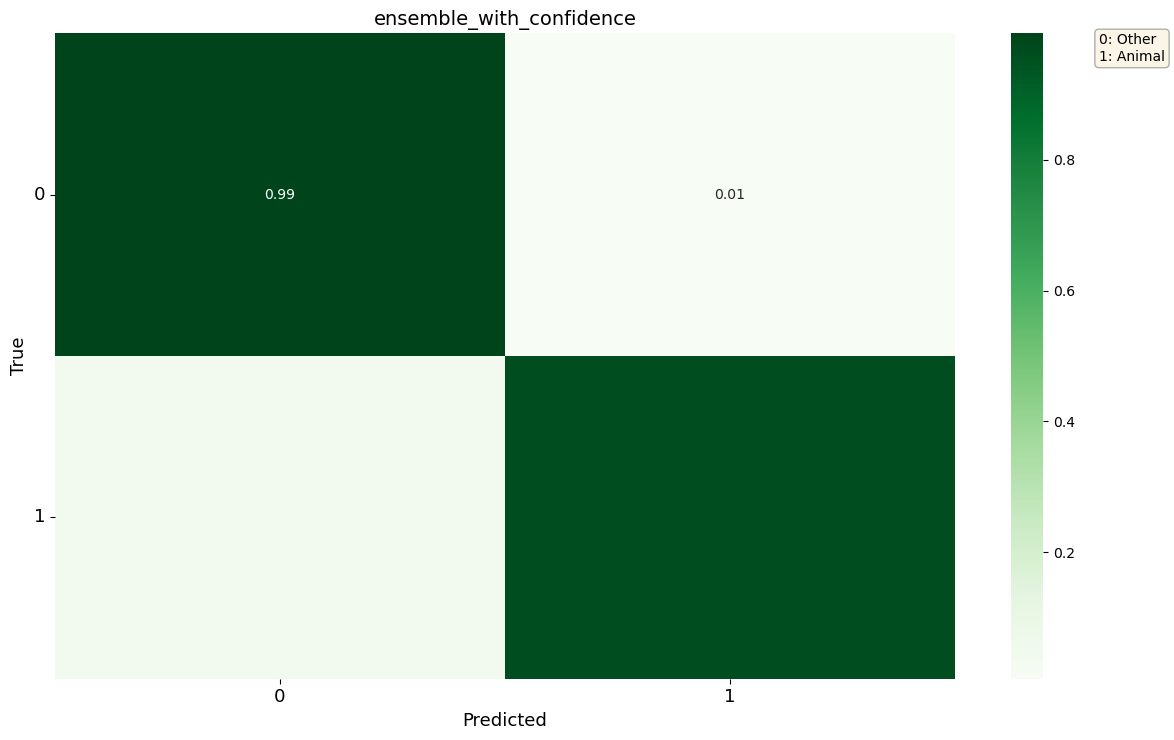

In [46]:
model = "ensemble_with_confidence"
experiment = "ensemble"
classification_type = "binary" 
label_to_numerical = label_to_numerical_binary
numerical_to_label = numerical_to_label_binary
# must be identical with the dir name
experiment_name = "rerun_finetuning_19-06-24" # TODO modify as needed
# gold standard col
target_col = 'true_label'
# hypothesis col
prediction_col = 'prediction'


filepath = f"./../../models/transformers/evaluations/{experiment_name}/{experiment}/{classification_type}/confidence_based_voting_predictions"
df = pd.read_csv(f'{filepath}/predictions.csv')
output_dir = f"{filepath}/results_w_CI"
os.makedirs(output_dir, exist_ok=True)

all_reports_ensemble, summary_ensemble = evaluate_predictions_with_ci(output_dir, model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

## Multi

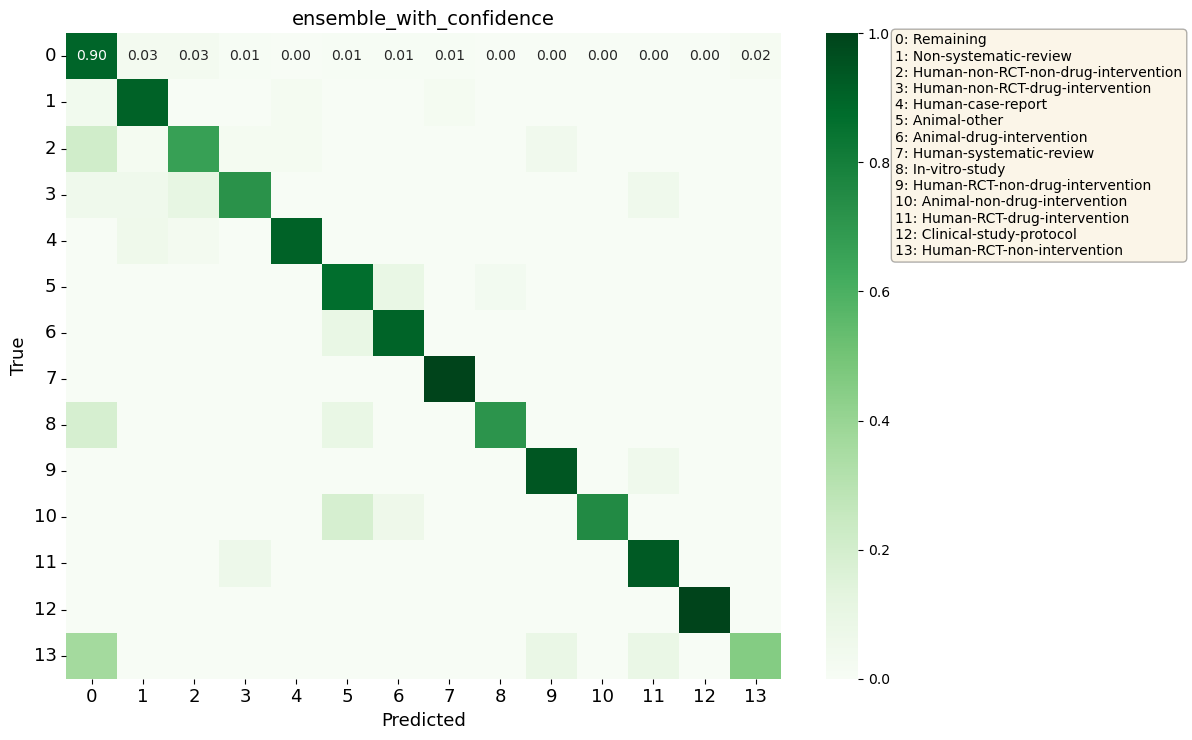

In [47]:
model = "ensemble_with_confidence"
experiment = "ensemble"
classification_type = "multi" 
label_to_numerical = label_to_numerical_multi
numerical_to_label = numerical_to_label_multi
# must be identical with the dir name
experiment_name = "rerun_finetuning_19-06-24" # TODO modify as needed
# gold standard col
target_col = 'true_label'
# hypothesis col
prediction_col = 'prediction'


filepath = f"./../../models/transformers/evaluations/{experiment_name}/{experiment}/{classification_type}/confidence_based_voting_predictions"
df = pd.read_csv(f'{filepath}/predictions.csv')
output_dir = f"{filepath}/results_w_CI"
os.makedirs(output_dir, exist_ok=True)

all_reports_ensemble_multi, summary_ensemble_multi = evaluate_predictions_with_ci(output_dir, model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

# Plot performance with Error Bars

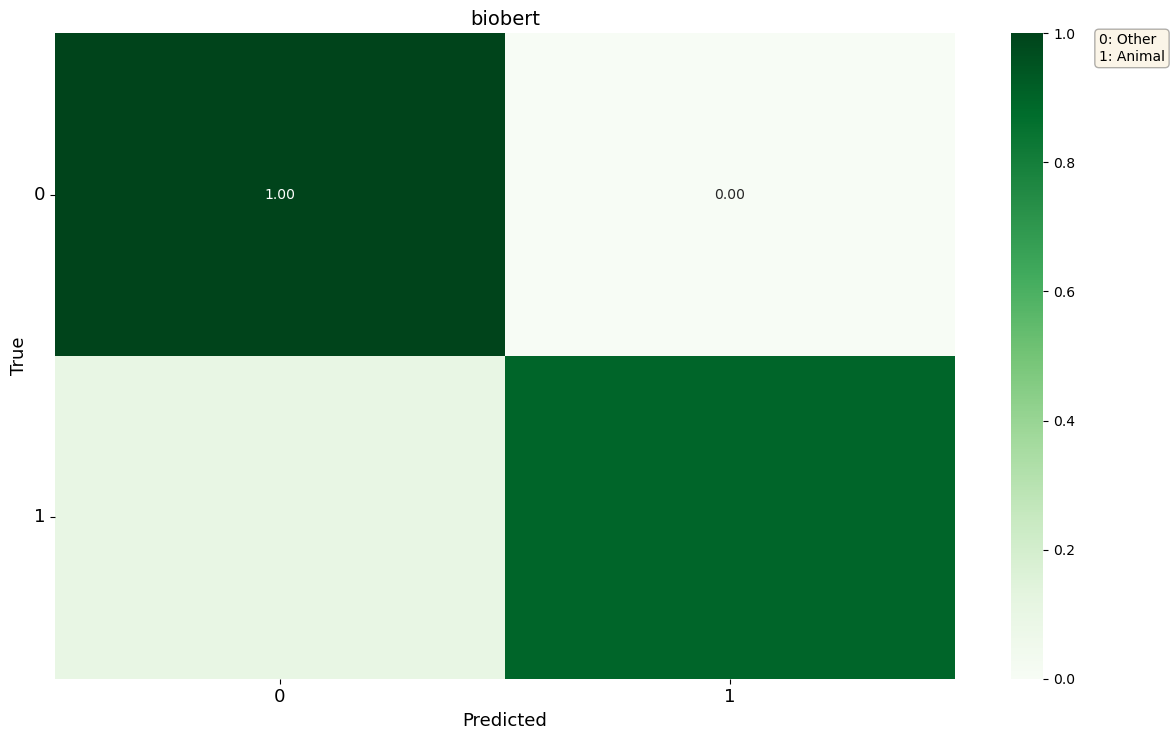

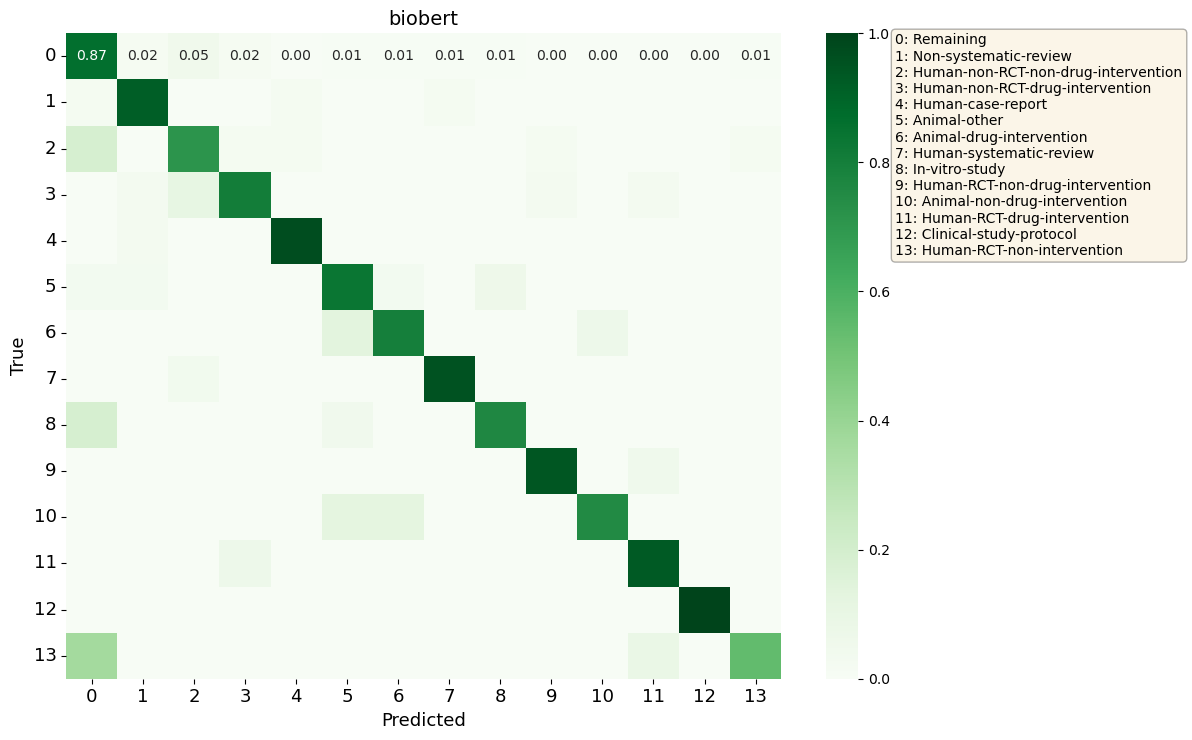

In [34]:
# rerun with biobert (winner)


# add necessary models to the list to iterate through
models = ['biobert']
# list all classification types in the exact format of their file names
classification_types = ["binary", "multi"] # does not work with "binary" !
# must be identical with the dir name
experiment_name = "rerun_finetuning_19-06-24" # TODO modify as needed
# gold standard col
target_col = 'true_label'
# hypothesis col
prediction_col = 'prediction'

for model in models: # iterate though all models
    for classification_type in classification_types: # iterate through classification types
        # ensure labels match classiciation type
        if classification_type == "binary":
            label_to_numerical = label_to_numerical_binary
            numerical_to_label = numerical_to_label_binary
        elif classification_type == "multi":
            label_to_numerical = label_to_numerical_multi
            numerical_to_label = numerical_to_label_multi

        common_path = f"./../../models/transformers/evaluations/{experiment_name}/{classification_type}"
        df = pd.read_csv(f'{common_path}/predictions/{model}.csv')
        output_dir = f"{common_path}/results_w_CI"
        os.makedirs(output_dir, exist_ok=True)

        all_reports_biobert, summary_df_biobert = evaluate_predictions_with_ci(output_dir, model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [35]:
all_reports_biobert

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.887,0.866,0.876,0.921,"(0.83, 0.926)","(0.807, 0.909)","(0.834, 0.919)","(0.895, 0.941)",172
Non-systematic-review,0.920,0.920,0.920,0.978,"(0.836, 0.963)","(0.836, 0.963)","(0.871, 0.969)","(0.961, 0.987)",75
Human-non-RCT-non-drug-intervention,0.682,0.714,0.698,0.951,"(0.534, 0.8)","(0.564, 0.828)","(0.586, 0.81)","(0.93, 0.967)",42
Human-non-RCT-drug-intervention,0.853,0.806,0.829,0.978,"(0.699, 0.936)","(0.65, 0.902)","(0.731, 0.926)","(0.961, 0.987)",36
Human-case-report,0.914,0.970,0.941,0.993,"(0.776, 0.97)","(0.847, 0.995)","(0.881, 1.001)","(0.981, 0.997)",33
Animal-other,0.765,0.839,0.800,0.976,"(0.6, 0.876)","(0.674, 0.929)","(0.692, 0.908)","(0.959, 0.986)",31
Animal-drug-intervention,0.828,0.800,0.814,0.979,"(0.655, 0.924)","(0.627, 0.905)","(0.703, 0.924)","(0.963, 0.988)",30
Human-systematic-review,0.875,0.955,0.913,0.993,"(0.69, 0.957)","(0.782, 0.992)","(0.826, 1.0)","(0.981, 0.997)",22
In-vitro-study,0.800,0.762,0.780,0.983,"(0.584, 0.919)","(0.549, 0.894)","(0.639, 0.922)","(0.968, 0.991)",21


In [54]:
def plot_winners_w_errorbar(output_dir, models):

    label_to_numerical = {
        'Remaining': 0,
        'Non-systematic-review': 1,
        'Human-non-RCT-non-drug-intervention': 2,
        'Human-non-RCT-drug-intervention': 3,
        'Human-case-report': 4,
        'Animal-other': 5,
        'Animal-drug-intervention': 6,
        'Human-systematic-review': 7,
        'In-vitro-study': 8,
        'Human-RCT-non-drug-intervention': 9,
        'Animal-non-drug-intervention': 10,
        'Human-RCT-drug-intervention': 11,
        'Clinical-study-protocol': 12,
        'Human-RCT-non-intervention': 13
    }
    classes_to_include = list(label_to_numerical.keys())

    # Filter dataframes
    all_reports_df_gpt4_filtered = all_reports_df_gpt4.loc[classes_to_include]
    all_reports_df_gpt3_filtered = all_reports_df_gpt3.loc[classes_to_include]
    all_reports_df_biobert_filtered = all_reports_biobert.loc[classes_to_include]
    all_reports_ensemble_multi_filtered = all_reports_ensemble_multi.loc[classes_to_include]

    # extract f1 and CI for all models
    # GPT-4, hierarchical
    f1_gpt4 = all_reports_df_gpt4_filtered['f1-score']
    f1_gpt4_lower = all_reports_df_gpt4_filtered['f1-score CI'].apply(lambda x: x[0])
    f1_gpt4_upper = all_reports_df_gpt4_filtered['f1-score CI'].apply(lambda x: x[1])
    # GPT-3.5, hierarchical
    f1_gpt3 = all_reports_df_gpt3_filtered['f1-score']
    f1_gpt3_lower = all_reports_df_gpt3_filtered['f1-score CI'].apply(lambda x: x[0])
    f1_gpt3_upper = all_reports_df_gpt3_filtered['f1-score CI'].apply(lambda x: x[1])
    # Biobert
    f1_biobert = all_reports_df_biobert_filtered['f1-score']
    f1_biobert_lower = all_reports_df_biobert_filtered['f1-score CI'].apply(lambda x: x[0])
    f1_biobert_upper = all_reports_df_biobert_filtered['f1-score CI'].apply(lambda x: x[1])

    # Ensemble
    f1_ensemble = all_reports_ensemble_multi_filtered['f1-score']
    f1_ensemble_lower = all_reports_ensemble_multi_filtered['f1-score CI'].apply(lambda x: x[0])
    f1_ensemble_upper = all_reports_ensemble_multi_filtered['f1-score CI'].apply(lambda x: x[1])

    # Calculate error bars
    f1_gpt4_errors = [f1_gpt4 - f1_gpt4_lower, f1_gpt4_upper - f1_gpt4]
    f1_gpt3_errors = [f1_gpt3 - f1_gpt3_lower, f1_gpt3_upper - f1_gpt3]
    f1_scibert_errors = [f1_biobert - f1_biobert_lower, f1_biobert_upper - f1_biobert]
    f1_ensemble_errors = [f1_ensemble - f1_ensemble_lower, f1_ensemble_upper - f1_ensemble]
    # Set the y positions for classes
    y_pos = np.arange(len(classes_to_include))

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Add horizontal stripes for better visibility
    for i in range(len(classes_to_include)):
        ax.axhspan(i - 0.5, i + 0.5, facecolor='gray' if i % 2 == 0 else 'white', alpha=0.15)

    ax.errorbar(f1_gpt4, y_pos - 0.2, xerr=f1_gpt4_errors, fmt='o', label='GPT-4', color='mediumvioletred', capsize=5)
    ax.errorbar(f1_gpt3, y_pos - 0.05, xerr=f1_gpt3_errors, fmt='o', label='GPT-3.5', color='steelblue', capsize=5)
    ax.errorbar(f1_biobert, y_pos + 0.05, xerr=f1_scibert_errors, fmt='o', label='BioBERT', color='seagreen', capsize=5)
    ax.errorbar(f1_ensemble, y_pos + 0.2, xerr=f1_ensemble_errors, fmt='o', label='Ensemble', color='darkorange', capsize=5)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes_to_include, fontsize=14)
    ax.set_xlabel('F1 Score', fontsize=14)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.set_ylim(-0.5, len(classes_to_include) - 0.5)
    # ax.set_title('F1 Score with per class Confidence Intervals')
    ax.legend(loc='lower left')

    # Add grid lines
    ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/ci_per_class_{models}.pdf')
    plt.show()


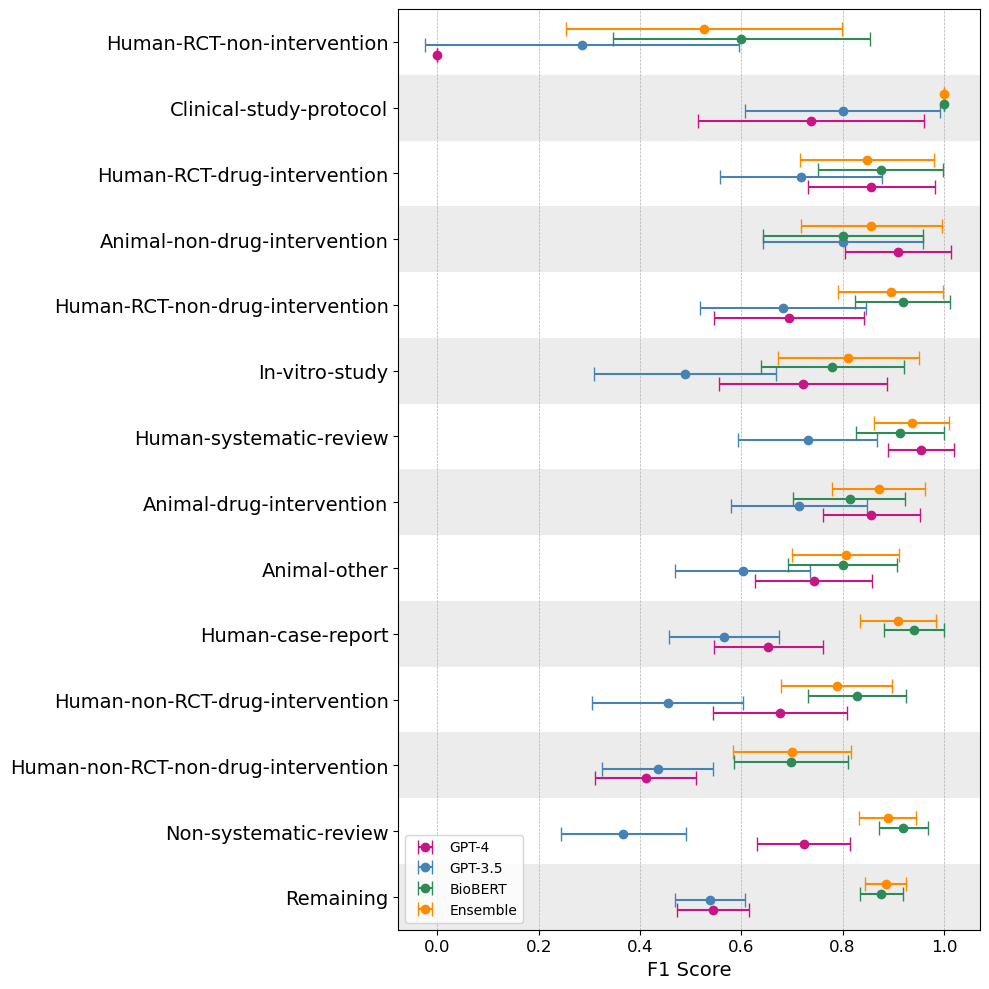

In [55]:
output_dir = "./../../model_comparisons"
os.makedirs(output_dir, exist_ok=True)
models = "GPT-4_GPT-3_BioBERT_ensemble"

plot_winners_w_errorbar(output_dir, models)

# Spiders

In [58]:
def plot_spider(output_dir, models):

    
    label_to_numerical = {
        'Remaining': 0,
        'Non-systematic-review': 1,
        'Human-non-RCT-non-drug-intervention': 2,
        'Human-non-RCT-drug-intervention': 3,
        'Human-case-report': 4,
        'Animal-other': 5,
        'Animal-drug-intervention': 6,
        'Human-systematic-review': 7,
        'In-vitro-study': 8,
        'Human-RCT-non-drug-intervention': 9,
        'Animal-non-drug-intervention': 10,
        'Human-RCT-drug-intervention': 11,
        'Clinical-study-protocol': 12,
        'Human-RCT-non-intervention': 13
    }
    classes_to_include = list(label_to_numerical.keys())


    # Filter dataframes
    all_reports_df_gpt4_filtered = all_reports_df_gpt4.loc[classes_to_include]
    all_reports_df_gpt3_filtered = all_reports_df_gpt3.loc[classes_to_include]
    all_reports_df_biobert_filtered = all_reports_biobert.loc[classes_to_include]
    all_reports_ensemble_multi_filtered = all_reports_ensemble_multi.loc[classes_to_include]

    # extract f1 and CI for all models
    # GPT-4, hierarchical
    f1_gpt4 = all_reports_df_gpt4_filtered['f1-score']
    # GPT-3.5, hierarchical
    f1_gpt3 = all_reports_df_gpt3_filtered['f1-score']
    # Biobert
    f1_biobert = all_reports_df_biobert_filtered['f1-score']
    # Ensemble
    f1_ensemble = all_reports_ensemble_multi_filtered['f1-score']


    # Number of categories (classes) and models
    categories = list(label_to_numerical.values())
    N = len(categories)

    # What will be the angle of each axis in the plot?
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Create a new figure
    fig = plt.figure(figsize=(11, 6))

    # Main subplot for the spider plot
    ax = fig.add_subplot(121, polar=True)

    # If you want the first axis to be on top
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], categories, color='black', size=12)

    # Draw y labels
    ax.set_rlabel_position(0)
    plt.yticks(np.arange(0, 1.1, step=0.2), ["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], color="black", size=10)
    plt.ylim(0, 1)

    # Plot each model
    for model, f1_scores, color in zip(['BioBERT', 'GPT-3.5', 'GPT-4', 'Ensemble'], [f1_biobert, f1_gpt3, f1_gpt4, f1_ensemble], ['seagreen', 'steelblue', 'mediumvioletred', 'darkorange']):
        values = [f1_scores[cat] for cat in categories]
        values += values[:1]
        ax.plot(angles, values, linewidth=1.2, linestyle='solid', label=model, color=color)
        ax.fill(angles, values, alpha=0.15, color=color)

    # Add legend to the main subplot
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=16, frameon=False)

    # Create legend mapping numbers back to text
    reverse_label_mapping = {v: k for k, v in label_to_numerical.items()}
    legend_labels = [f"{num}: {reverse_label_mapping[num]}" for num in categories]

    # Subplot for the legend insert
    legend_ax = fig.add_subplot(122)
    legend_ax.axis('off')

    # Add custom legend for class names
    legend_ax.text(0.3, 0.5, '\n'.join(legend_labels), fontsize=12, bbox=dict(facecolor='wheat', alpha=0.5))
    # adjust layout
    plt.subplots_adjust(top=1, bottom=0)

    # Save to PDF
    plt.savefig(f'{output_dir}/spider_{models}.pdf')

    # Show the plot
    plt.show()



/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_3574/1291238311.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [f1_scores[cat] for cat in categories]


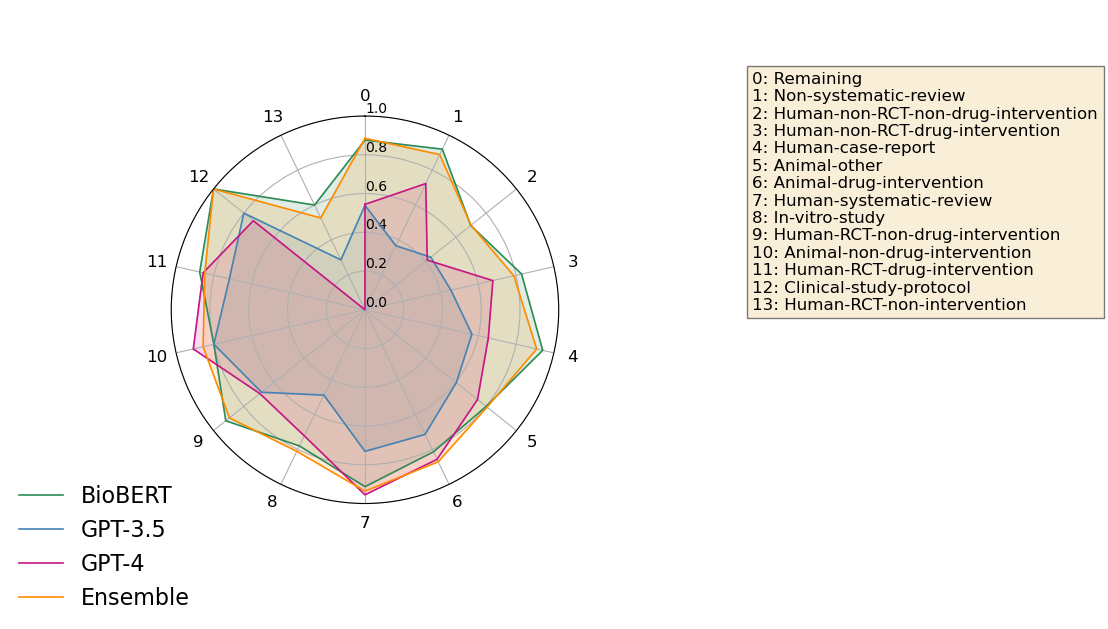

In [59]:
output_dir = "./../../model_comparisons"
os.makedirs(output_dir, exist_ok=True)
models = "GPT-4_GPT-3_BioBERT_Ensemble"

plot_spider(output_dir, models)